In [8]:
from binance.spot import Spot 
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import os
import pyspark.sql as ps
from dotenv import load_dotenv
load_dotenv()
load_dotenv(verbose=True)

False

In [9]:
# Create a client
BINANCE_API_KEY = os.environ.get('BINANCE_API_KEY')
BINANCE_API_SECRET = os.environ.get('BINANCE_API_SECRET')
client = Spot(key=BINANCE_API_KEY, secret=BINANCE_API_SECRET)
spark = ps.SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "4096m").\
        getOrCreate()
spark.sparkContext.setLogLevel("WARN")

22/11/08 22:57:42 WARN Utils: Your hostname, tramngu-OptiPlex-7010 resolves to a loopback address: 127.0.1.1; using 192.168.1.15 instead (on interface eno1)
22/11/08 22:57:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/08 22:57:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/08 22:57:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/11/08 22:57:44 WARN StandaloneAppClient$ClientEndpoint: Failed to connect to master spark-master:7077
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anon$1.run(StandaloneAppClient.scala:107)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/tramngu/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/tramngu/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [10]:
import pandas as pd
day_to_query = 800
duration_each_day = 60 * 60 * 24 * 1000

# start day
today = datetime.utcnow().replace(hour=7, minute=0, second=0, microsecond=0)
today_timestamp = int(today.timestamp() * 1000)

start_timestamp = today_timestamp - day_to_query * duration_each_day
end_timestamp = today_timestamp

exchanges = client.exchange_info()
symbols = list(map(lambda item: item.get('symbol'), exchanges.get('symbols')))
columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
df = None
for symbol in ["BTCUSDT"]:
    if symbol.endswith('USDT'):
        # os.mkdir(f"./data/{symbol}")
        try:
            for timestamp in range(start_timestamp, end_timestamp, duration_each_day * 30):
                data = client.klines(symbol, "1d", limit=500,startTime=timestamp,endTime=timestamp + duration_each_day * 30,)

                if start_timestamp == timestamp:
                    df = spark.createDataFrame(data, schema=columns)
                else:
                    df = df.union(spark.createDataFrame(data))
#               df.write.option("header",True) \
#                  .mode("overwrite") \
#                  .parquet(f"hdfs://hadoop-namenode:9000/crypto/{symbol}/30m_{datetime.fromtimestamp(timestamp/1000).strftime('%m_%d')}.parquet")
        except Exception as err:
            print(err)
            

name 'spark' is not defined


In [11]:
from pyspark.sql.functions import to_date,from_unixtime
from pyspark.sql.types import DateType,FloatType,IntegerType

from pyspark.ml import regression

selected = df.select(['close','close_time'])
# seperate data into train and test
# train_data, test_data = selected.randomSplit([0.8, 0.2])
# train_data = train_data.withColumn('close', train_data['close'].cast(IntegerType()))
# train_data = train_data.withColumn('open', train_data['open'].cast(IntegerType()))

pddf = selected.toPandas()
pddf['close_time'] = pddf['close_time'].apply(lambda time: datetime.fromtimestamp(time/1000))
pddf['close'] = pddf['close'].apply(lambda price: float(price))
pddf = pddf.set_index('close_time')


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.plot(pddf['close'])
plt.ylabel('close price')
plt.xlabel('date')
plt.show()

AttributeError: 'NoneType' object has no attribute 'select'

In [11]:
selected = df
selected.select(['volume', 'number_of_trades', 'close']).show()

+---------------+----------------+--------------+
|         volume|number_of_trades|         close|
+---------------+----------------+--------------+
| 53998.23123100|          862654|11461.43000000|
| 63246.03638300|          959270|11330.38000000|
| 45953.90836500|          719985|11526.91000000|
| 32973.79920000|          611834|11465.84000000|
| 43177.87905400|          756541|11711.16000000|
| 55353.61774400|          822062|11649.51000000|
| 78148.19366800|         1321492|11921.97000000|
| 87221.84560200|         1373524|11388.54000000|
|121950.10601500|         1611610|10140.85000000|
| 92733.59911300|         1434860|10446.25000000|
| 90001.60556800|         1476782|10166.69000000|
| 56368.78881500|         1053192|10256.20000000|
| 62620.23067600|          927363|10373.44000000|
| 73491.87841800|         1048125|10126.65000000|
| 49347.11377600|          755560|10219.20000000|
| 58253.75375000|          851877|10336.87000000|
| 43830.25446700|          637869|10387.89000000|


### Question 1: How open price look like respectively to volume, number_of_trades

In [22]:
# from pyspark.ml.feature import MinMaxScaler
# import column transformer and one hot encoder
from pyspark.ml.feature import VectorAssembler,MinMaxScaler,StandardScaler

selected = selected.select(['volume', 'number_of_trades', 'close', 'close_time']) \
    .withColumn('volume', selected['volume'].cast(FloatType())) \
    .withColumn('number_of_trades', selected['number_of_trades'].cast(IntegerType())) \
    .withColumn('close', selected['close'].cast(FloatType()))

assembler = VectorAssembler(inputCols=['close'],outputCol='price')
output = assembler.transform(selected)

stdScaler = StandardScaler(inputCol='price',outputCol='scaled_price',withMean=True)

stdScaler = stdScaler.fit(output)
data = stdScaler.transform(output)
data = data.select(['scaled_price'])
data.show()

+--------------------+
|        scaled_price|
+--------------------+
|[-1.612208519039605]|
|[-1.6209368245523...|
|[-1.607847325692328]|
|[-1.6119147895586...|
|[-1.5955757294503...|
|[-1.5996818282395...|
|[-1.5815351870849...|
|[-1.6170631857199...|
|[-1.7001630673378...|
|[-1.6798224959083...|
|[-1.698441992095342]|
|[-1.6924803763370...|
|[-1.6846718291480...|
|[-1.7011087774027...|
|[-1.6949446860301...|
|[-1.6871075203798...|
|[-1.6837094683420...|
|[-1.6801774949134...|
|[-1.6873765989587...|
|[-1.6648022265342...|
+--------------------+
only showing top 20 rows



In [25]:
import numpy as np



array(DataFrame[scaled_price: vector], dtype=object)

In [12]:
from pyspark.ml.regression import LinearRegression

regression = LinearRegression(featuresCol='transaction_factor',labelCol='close')
regression = regression.fit(train_data)

pred_values = regression.evaluate(test_data)

regression.coefficients

AssertionError: 

In [47]:
regression.intercept

27783.37504543537

In [52]:
pred_values.predictions.show()

+--------------------+--------+-------------+------------------+
|  transaction_factor|   close|   close_time|        prediction|
+--------------------+--------+-------------+------------------+
|[59316.27734375,1...|40480.01|1650585599999| 41723.69031030423|
|[46664.01953125,1...|39709.18|1650671999999|   33783.461131103|
|[20291.423828125,...| 39441.6|1650758399999| 39421.53499886611|
|[26703.611328125,...|39450.13|1650844799999| 40268.24939613529|
|[63037.12890625,1...|40426.08|1650931199999|31572.843193738725|
|[66650.2578125,13...|38112.65|1651017599999|32721.060642134766|
|[57083.12109375,1...|39235.72|1651103999999| 33641.39671473384|
|[56086.671875,113...|39742.07|1651190399999| 31023.52106717946|
|[51453.65625,1101...|38596.11|1651276799999| 32748.57145299173|
|[35321.19140625,1...| 37630.8|1651363199999|39923.211326721605|
|[38812.2421875,10...|38468.35|1651449599999| 37891.77086909305|
|[53200.92578125,1...|38525.16|1651535999999|30090.806611468153|
|[40316.453125,100...|377

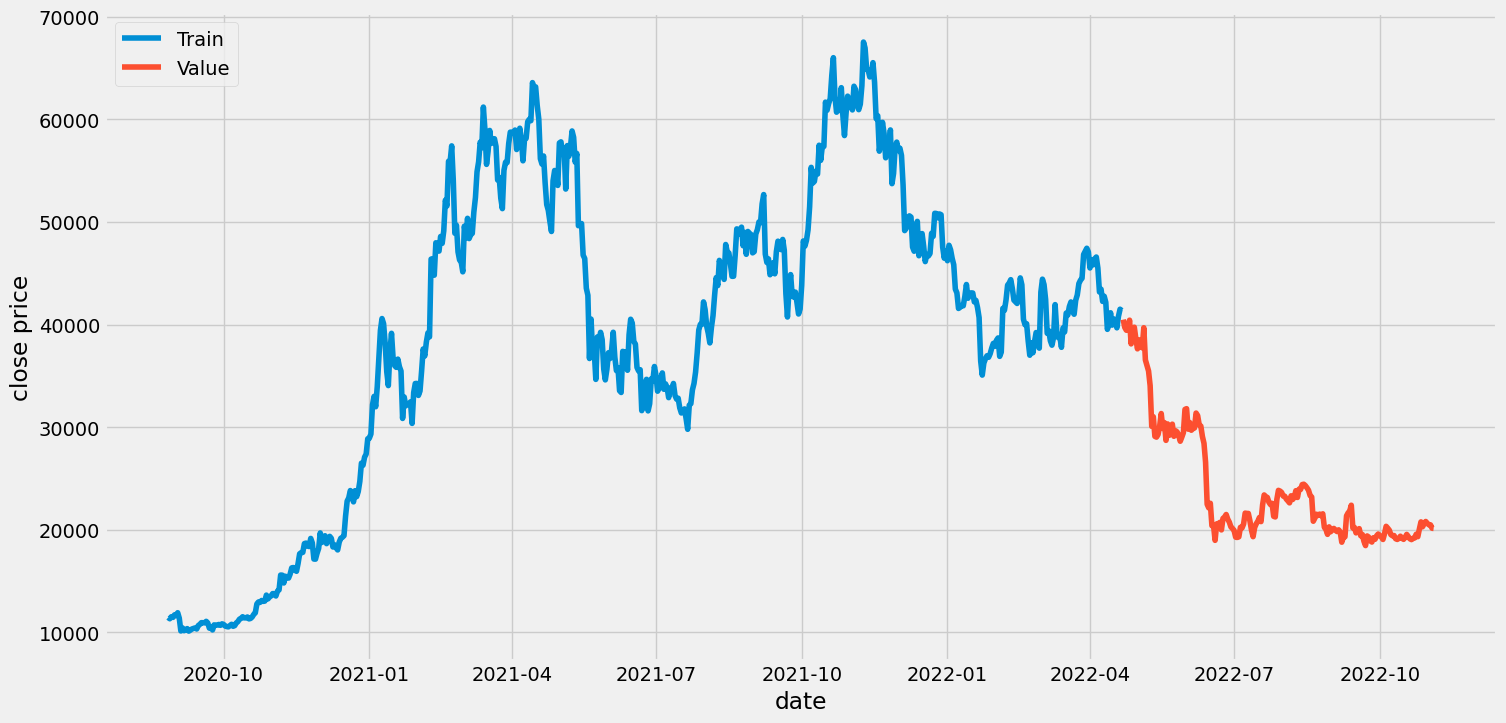

In [58]:
pddf = train_data.toPandas()
pddf['close_time'] = pddf['close_time'].apply(lambda time: datetime.fromtimestamp(time/1000))
pddf['close'] = pddf['close'].apply(lambda price: float(price))
pddf = pddf.set_index('close_time')

plt.figure(figsize=(16,8))
plt.plot(pddf['close'])
plt.ylabel('close price')
plt.xlabel('date')

pddf = pred_values.predictions.toPandas()
pddf['close_time'] = pddf['close_time'].apply(lambda time: datetime.fromtimestamp(time/1000))
pddf['close'] = pddf['close'].apply(lambda price: float(price))
pddf = pddf.set_index('close_time')

plt.plot(pddf['close'])
# plt.plot(pddf['prediction'])
plt.legend(['Train', 'Value', 'Pred'],loc='upper left')
plt.show()

In [63]:
# symbol = "ETHUSDT"
# timestamp = "30m_10_30"
# df_load = spark.read.parquet(f"hdfs://hadoop-namenode:9000/crypto/{symbol}/{timestamp}.parquet")